DEM CRS: EPSG:27700
DEM shape: (492, 264)
DEM nodata: nan
DEM bounds: BoundingBox(left=0.00012004771269857883, bottom=-0.0003991583362221718, right=660000.0001200477, top=1229999.9996008417)

Land-cover composition on LAND (after matching DEM grid):
   0  Unclassified / Masked            70.99%
   1  Deciduous woodland                2.21%
   2  Coniferous woodland               1.80%
   3  Arable                            6.10%
   4  Improved grassland                8.78%
   5  Neutral grassland                 0.09%
   6  Calcareous grassland              0.18%
   7  Acid grassland                    2.53%
   8  Fen                               0.05%
   9  Heather                           1.08%
  10  Heather grassland                 1.47%
  11  Bog                               1.20%
  12  Inland rock                       0.18%
  13  Saltwater                         0.34%
  14  Freshwater                        0.30%
  15  Supralittoral rock                0.06%
  16  Supralit

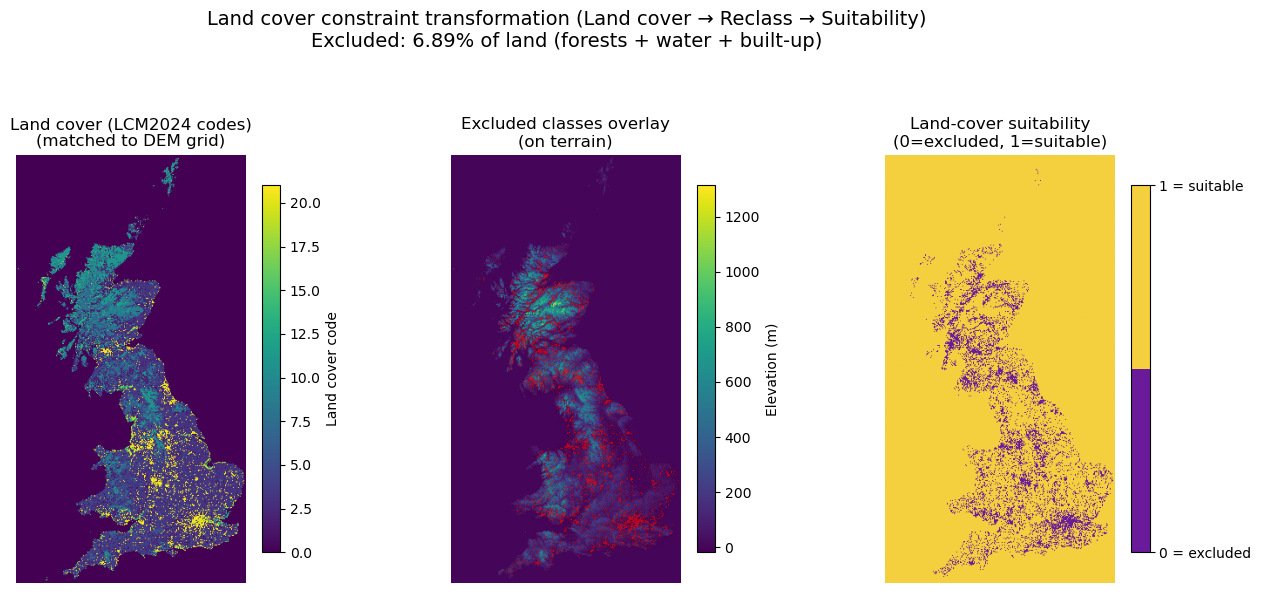


Saved: /Users/wangbobo/Desktop/2nd_Assignment-20251222/datasets/outputs/figure_landcover_triplet.png
Saved: /Users/wangbobo/Desktop/2nd_Assignment-20251222/datasets/outputs/landcover_suitability_0_1.tif


In [1]:
import os
import numpy as np
import rasterio
from rasterio.warp import reproject, Resampling
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


TERRAIN_DIR = "/Users/wangbobo/Desktop/2nd_Assignment-20251222/datasets"

TERRAIN_TIF = os.path.join(TERRAIN_DIR, "terrain.tif")

LANDCOVER_DIR = "/Users/wangbobo/Desktop/uk land cover/data/0e3ab6f8-4a20-4a60-a804-e144fb0bde39"
LANDCOVER_TIF = os.path.join(LANDCOVER_DIR, "gblcm2024_25m.tif")

OUT_DIR = os.path.join(TERRAIN_DIR, "outputs")
os.makedirs(OUT_DIR, exist_ok=True)


LCM_CLASSES = {
    0:  "Unclassified / Masked",
    1:  "Deciduous woodland",
    2:  "Coniferous woodland",
    3:  "Arable",
    4:  "Improved grassland",
    5:  "Neutral grassland",
    6:  "Calcareous grassland",
    7:  "Acid grassland",
    8:  "Fen",
    9:  "Heather",
    10: "Heather grassland",
    11: "Bog",
    12: "Inland rock",
    13: "Saltwater",
    14: "Freshwater",
    15: "Supralittoral rock",
    16: "Supralittoral sediment",
    17: "Littoral rock",
    18: "Littoral sediment",
    19: "Saltmarsh",
    20: "Urban",
    21: "Suburban",
}


EXCLUDE_CODES = [1, 2, 13, 14, 20, 21]


with rasterio.open(TERRAIN_TIF) as dem_src:
    dem = dem_src.read(1).astype("float32")
    dem_transform = dem_src.transform
    dem_crs = dem_src.crs
    dem_nodata = dem_src.nodata
    dem_bounds = dem_src.bounds

land_mask = np.isfinite(dem) if (dem_nodata is None or np.isnan(dem_nodata)) else (dem != dem_nodata)

print("DEM CRS:", dem_crs)
print("DEM shape:", dem.shape)
print("DEM nodata:", dem_nodata)
print("DEM bounds:", dem_bounds)


with rasterio.open(LANDCOVER_TIF) as lc_src:
    # Use band 1 = _mode (dominant class)
    lc_mode = lc_src.read(1)
    lc_crs = lc_src.crs
    lc_transform = lc_src.transform
    lc_nodata = lc_src.nodata

lc_on_dem = np.full(dem.shape, 0, dtype=np.int16)  # default 0=unclassified
reproject(
    source=lc_mode,
    destination=lc_on_dem,
    src_transform=lc_transform,
    src_crs=lc_crs,
    dst_transform=dem_transform,
    dst_crs=dem_crs,
    resampling=Resampling.nearest,   # IMPORTANT for categorical data
    src_nodata=lc_nodata,
    dst_nodata=0
)


vals, counts = np.unique(lc_on_dem[land_mask], return_counts=True)
total_land = counts.sum()

print("\nLand-cover composition on LAND (after matching DEM grid):")
for v, c in zip(vals, counts):
    name = LCM_CLASSES.get(int(v), f"Unknown({int(v)})")
    print(f"  {int(v):>2}  {name:<30}  {c/total_land*100:6.2f}%")


excluded = np.isin(lc_on_dem, EXCLUDE_CODES) & land_mask
suitability = np.ones(dem.shape, dtype=np.uint8)   # 1=suitable by default
suitability[excluded] = 0
# Keep sea/nodata as NaN so it doesn't paint big rectangles
suitability_plot = suitability.astype("float32")
suitability_plot[~land_mask] = np.nan

excluded_pct = excluded.sum() / land_mask.sum() * 100.0
print(f"\nExcluded % of LAND cells = {excluded_pct:.2f}% (EXCLUDE_CODES={EXCLUDE_CODES})")


suit_cmap = ListedColormap(["#6a1b9a", "#f4d03f"]) 

fig = plt.figure(figsize=(14, 6))
fig.suptitle(
    f"Land cover constraint transformation (Land cover → Reclass → Suitability)\n"
    f"Excluded: {excluded_pct:.2f}% of land (forests + water + built-up)",
    fontsize=14
)

ax1 = plt.subplot(1, 3, 1)
im1 = ax1.imshow(np.where(land_mask, lc_on_dem, np.nan))
ax1.set_title("Land cover (LCM2024 codes)\n(matched to DEM grid)")
ax1.axis("off")
cbar1 = plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
cbar1.set_label("Land cover code")


ax2 = plt.subplot(1, 3, 2)
im2 = ax2.imshow(dem, vmin=np.nanmin(dem), vmax=np.nanmax(dem))
ax2.set_title("Excluded classes overlay\n(on terrain)")
ax2.axis("off")
plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04).set_label("Elevation (m)")


overlay = np.zeros((*dem.shape, 4), dtype=np.float32)
overlay[excluded] = [1, 0, 0, 0.6]  
ax2.imshow(overlay)

ax3 = plt.subplot(1, 3, 3)
im3 = ax3.imshow(suitability_plot, cmap=suit_cmap, vmin=0, vmax=1)
ax3.set_title("Land-cover suitability\n(0=excluded, 1=suitable)")
ax3.axis("off")
cbar3 = plt.colorbar(im3, ax=ax3, fraction=0.046, pad=0.04)
cbar3.set_ticks([0, 1])
cbar3.set_ticklabels(["0 = excluded", "1 = suitable"])

out_png = os.path.join(OUT_DIR, "figure_landcover_triplet.png")
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.savefig(out_png, dpi=300)
plt.show()

print("\nSaved:", out_png)

# =========================
# 9) OPTIONAL: save the final suitability raster to GeoTIFF
# =========================
out_tif = os.path.join(OUT_DIR, "landcover_suitability_0_1.tif")
with rasterio.open(
    out_tif, "w",
    driver="GTiff",
    height=dem.shape[0],
    width=dem.shape[1],
    count=1,
    dtype=rasterio.uint8,
    crs=dem_crs,
    transform=dem_transform,
    nodata=255,
    compress="lzw"
) as dst:
    out_arr = suitability.copy()
    out_arr[~land_mask] = 255
    dst.write(out_arr, 1)

print("Saved:", out_tif)